In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
random.seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

## Preliminary

In [3]:
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset

In [4]:
aptamer_dataset_file = "../data/aptamer_dataset.json"

def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    full_dataset = []
    aptamers = []
    peptides = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                full_dataset.append((aptamer, peptide))
    full_dataset = list(set(full_dataset)) #removed duplicates
    for pair in full_dataset:
        aptamers.append(pair[0])
        peptides.append(pair[1])
    return full_dataset, aptamers, peptides 

In [5]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, training_set):
        super(TrainDataset, self).__init__() 
        self.training_set = training_set
        
    def __len__(self):
        return len(self.training_set)

    def __getitem__(self, idx):
        aptamer, peptide = self.training_set[idx]
        return aptamer, peptide
    
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_set):
        super(TestDataset, self).__init__() 
        self.test_set = test_set
        
    def __len__(self):
        return len(self.test_set)

    def __getitem__(self, idx):
        aptamer, peptide = self.test_set[idx]
        return aptamer, peptide

In [6]:
full_dataset, aptamers, peptides = construct_dataset()
n = len(full_dataset)
training_set = full_dataset[:int(0.8*n)]
test_set = full_dataset[int(0.8*n):]
train_dataset = TrainDataset(training_set)
test_dataset = TestDataset(test_set)
train_loader = torch.utils.data.DataLoader(train_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)

## One-hot encoding

In [7]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence_list, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    
    one_hot = np.zeros((len(sequence_list), len(sequence_list[0]), len(letters)))
    
    for j in range(len(sequence_list)):
        sequence = sequence_list[j]
        for i in range(len(sequence)):
            element = sequence[i]
            idx = letters.index(element)
            one_hot[j][i][idx] = 1
    return one_hot

## NN Models

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(40, 20, 1)
        self.cnn_apt_2 = nn.Conv2d(20, 10, 1)
        self.cnn_apt_3 = nn.Conv2d(10, 1, 1)
        self.fc_apt_1 = nn.Linear(160, 1)
        
        self.cnn_pep_1 = nn.Conv2d(8, 4, 1)
        self.cnn_pep_2 = nn.Conv2d(4, 3, 1)
        self.fc_pep_1 = nn.Linear(64, 1)
        
        self.pool = nn.MaxPool2d(1, 1)
        self.relu = nn.ReLU()
                
        self.sequential_pep = nn.Sequential(self.cnn_pep_1,
                                            self.relu, 
                                            self.pool, 
                                            self.cnn_pep_2)
        
        self.sequential_apt = nn.Sequential(self.cnn_apt_1, 
                                            self.relu, 
                                            self.pool, 
                                            self.cnn_apt_2, 
                                            self.relu, 
                                            self.pool, 
                                            self.cnn_apt_3)
        
        self.fc1 = nn.Linear(64, 1)
        
    def forward(self, apt, pep):
        apt = self.sequential_apt(apt).cuda()
        pep = self.sequential_pep(pep).cuda()
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [9]:
class TwoLayer(nn.Module):
    def __init__(self):
        super(TwoLayer, self).__init__(),
        self.linear_apt_1 = nn.Linear(40, 20, 1)
        self.linear_apt_2 = nn.Linear(20, 10, 1)
        
        self.linear_pep_1 = nn.Linear(8, 4, 1)
        self.linear_pep_2 = nn.Linear(4, 2, 1)
        
        self.relu = nn.ReLU()
        
        self.sequential_pep = nn.Sequential(self.linear_pep_1,
                                            self.relu,
                                            self.linear_pep_2)
        
        self.sequential_apt = nn.Sequential(self.linear_apt_1,
                                            self.relu,
                                            self.linear_apt_2)
        
        self.fc1 = nn.Linear(64, 1)
        
    def forward(self, apt, pep):
        apt = self.sequential_apt(apt).cuda()
        pep = self.sequential_pep(pep).cuda()
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x

In [10]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        nn.init.zeros_(m.bias.data)

## Sampling

In [11]:
# Sample x from P_X (assume peptides follow NNK)
def get_x():
    x_idx = np.random.choice(20, 7, p=pvals)
    x = "M"
    for i in x_idx:
        x += aa_list[i]
    return x

# Sample y from P_Y (assume apatamers follow uniform)
def get_y():
    y_idx = np.random.randint(0, 4, 40)
    y = ""
    for i in y_idx:
        y += na_list[i]
    return y

# Generate uniformly from S without replacement
def get_xy(k):
    samples = [full_dataset[i] for i in np.random.choice(len(full_dataset), k, replace=False)]
    return samples

# S' contains S with double the size of S (domain for Importance Sampling)
def get_S_prime(k):
    S_prime = full_dataset[:]
    for _ in range(k):
        S_prime.append((get_y(), get_x()))
    return list(set(S_prime))

# Sample from S' without replacement
def get_xy_prime(k):
    samples = [S_prime[i] for i in np.random.choice(len(S_prime), k, replace=False)]
    return samples

# Returns pmf of a peptide
def get_x_pmf(x):
    pmf = 1
    for char in x[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf

# Returns pmf of an aptamer
def get_y_pmf():
    return 0.25**40

S_prime = get_S_prime(n)

## SGD

In [12]:
def update(type="original"):
    if type == "original":
        xy = get_xy(1)[0]
    else:
        xy = get_xy_prime(1)[0]
    x = one_hot(xy[0], seq_type='aptamer') 
    y = one_hot(xy[1], seq_type='peptide') 
    x = torch.FloatTensor(np.reshape(x, (1, x.shape[0], x.shape[1], x.shape[2])))
    y = torch.FloatTensor(np.reshape(y, (1, y.shape[0], y.shape[1], y.shape[2])))
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return xy, out

In [13]:
def sgd(t=1000, #num of iter
        lamb=1e-5, #hyperparam
        gamma=1e-4): #step size
    
    model.train()
    for a, _ in enumerate(tqdm.tqdm(range(t))):
        xy, out = update()
        out.retain_grad()
        log_out = torch.log(out)
        log_out.retain_grad()
        model.zero_grad()
        log_out.backward()
        
        xy_prime, out_prime = update("prime")
        out_prime = out_prime * get_x_pmf(xy_prime[0]) * get_y_pmf() * 2 * n
        out_prime.retain_grad()
        model.zero_grad()
        out_prime.backward()
        
        const = 0 if xy_prime in full_dataset else 1 #indicator
        g = log_out.grad - lamb*const*out_prime.grad
        g = g.item()
        
        #Update the weights according to SGD
        for param in model.parameters():
            param.data += gamma * g

## Recall & evaluate

In [14]:
# Eval on test set of size k (split from our dataset)
def recall_eval(k):
    correct = 0
    count = 0
    binding_outputs = []
    model.eval()
    for _, (aptamer, peptide) in enumerate(tqdm.tqdm(test_loader)):
        if count > k:
            break
        pep = one_hot(peptide, seq_type='peptide')
        apt = one_hot(aptamer, seq_type='aptamer')
        pep = torch.FloatTensor(np.reshape(pep, (1, pep.shape[1], pep.shape[2], pep.shape[0]))).cuda()
        apt = torch.FloatTensor(np.reshape(apt, (1, apt.shape[1], apt.shape[2], apt.shape[0]))).cuda()
        output = model(apt, pep).cpu().detach().numpy().flatten()[0]
        binding_outputs.append('%.2f'% output)
        if output > 0.5:
            correct += 1
        count += 1
    recall = 100*correct/k #recall rate of k samples
    return recall, binding_outputs #list of k outputs

In [15]:
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 1, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 1, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, apt.shape[0], apt.shape[2], apt.shape[1]))).cuda() #(1, 40, 4, 1)
    pep = torch.FloatTensor(np.reshape(pep, (1, pep.shape[0], pep.shape[2], pep.shape[1]))).cuda() #(1, 8, 20, 1)
    return apt, pep

# Eval on m new unseen pairs(not in our dataset)
def evaluate(m):
    model.eval()
    outputs = []
    for _ in range(m):
        x, y = get_x(), get_y()
        apt, pep = convert(y, x)
        output = model(apt, pep).cpu().detach().numpy().flatten()[0]
        outputs.append('%.2f'% output)
    return outputs #list of m outputs

## Hyperparameter tuning

In [16]:
gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
lambdas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
recalls = []
scores = []

m = int(3e3) # number of unknown samples
k = int(5e2) # number of binding samples (test set size is 118262, k is just some limit we set)

M = np.zeros((len(gammas), len(lambdas)))
for g in range(len(gammas)):
    for l in range(len(lambdas)):
        model = ConvNet()
        model.apply(weights_init)
        model.cuda()
        print("Training...")
        sgd(t=1000, gamma=gammas[g], lamb=lambdas[l])
        print("Evaluating...")
        # use for AUC
        recall, binding_outputs = recall_eval(k)
        unknown_outputs = evaluate(m)
        scores.append((unknown_outputs, binding_outputs))
        # use for heatmap
        M[g][l] += recall
        recalls.append(recall)
        print("Recall with gamma: "+ str(gammas[g]) + " , lambda: " + str(lambdas[l]) + " recall: ", '%.2f'% recall)

  0%|          | 0/1000 [00:00<?, ?it/s]

Training...


  0%|          | 26/118262 [00:00<07:53, 249.88it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 0.1 , lambda: 0.1 recall:  100.20
Training...


  0%|          | 22/118262 [00:00<09:10, 214.68it/s]

Evaluating...


  0%|          | 1/1000 [00:00<02:36,  6.38it/s]

Recall with gamma: 0.1 , lambda: 0.01 recall:  100.20
Training...


  0%|          | 21/118262 [00:00<09:48, 200.89it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 0.1 , lambda: 0.001 recall:  100.20
Training...


  0%|          | 29/118262 [00:00<06:49, 288.83it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 0.1 , lambda: 0.0001 recall:  100.20
Training...


  0%|          | 46/118262 [00:00<04:20, 453.49it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 0.1 , lambda: 1e-05 recall:  100.20
Training...


  0%|          | 22/118262 [00:00<08:57, 219.87it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 0.01 , lambda: 0.1 recall:  100.20
Training...


  0%|          | 44/118262 [00:00<04:29, 438.57it/s]

Evaluating...


  0%|          | 1/1000 [00:00<02:58,  5.59it/s]

Recall with gamma: 0.01 , lambda: 0.01 recall:  100.20
Training...


  0%|          | 29/118262 [00:00<06:50, 287.88it/s]

Evaluating...


  0%|          | 1/1000 [00:00<02:30,  6.65it/s]

Recall with gamma: 0.01 , lambda: 0.001 recall:  100.20
Training...


  0%|          | 26/118262 [00:00<07:54, 249.43it/s]

Evaluating...


  0%|          | 1/1000 [00:00<02:20,  7.10it/s]

Recall with gamma: 0.01 , lambda: 0.0001 recall:  100.20
Training...


  0%|          | 32/118262 [00:00<06:19, 311.37it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 0.01 , lambda: 1e-05 recall:  100.20
Training...


  0%|          | 21/118262 [00:00<09:27, 208.18it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 0.001 , lambda: 0.1 recall:  100.20
Training...


  0%|          | 44/118262 [00:00<04:30, 437.77it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 0.001 , lambda: 0.01 recall:  100.20
Training...


  0%|          | 22/118262 [00:00<09:10, 214.94it/s]

Evaluating...


  0%|          | 1/1000 [00:00<03:00,  5.52it/s]

Recall with gamma: 0.001 , lambda: 0.001 recall:  100.20
Training...


  0%|          | 20/118262 [00:00<09:57, 197.86it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 0.001 , lambda: 0.0001 recall:  100.20
Training...


  0%|          | 21/118262 [00:00<09:34, 205.75it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 0.001 , lambda: 1e-05 recall:  100.20
Training...


  0%|          | 40/118262 [00:00<04:58, 396.62it/s]

Evaluating...


  0%|          | 1/1000 [00:00<02:49,  5.91it/s]

Recall with gamma: 0.0001 , lambda: 0.1 recall:  24.00
Training...


  0%|          | 36/118262 [00:00<05:30, 358.24it/s]

Evaluating...


  0%|          | 2/1000 [00:00<01:14, 13.47it/s]

Recall with gamma: 0.0001 , lambda: 0.01 recall:  100.20
Training...


  0%|          | 43/118262 [00:00<04:42, 418.67it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 0.0001 , lambda: 0.001 recall:  100.20
Training...


  0%|          | 35/118262 [00:00<05:41, 346.33it/s]

Evaluating...


  0%|          | 1/1000 [00:00<02:56,  5.67it/s]

Recall with gamma: 0.0001 , lambda: 0.0001 recall:  100.20
Training...


  0%|          | 45/118262 [00:00<04:29, 439.39it/s]

Evaluating...


  0%|          | 1/1000 [00:00<02:03,  8.10it/s]

Recall with gamma: 0.0001 , lambda: 1e-05 recall:  100.20
Training...


  0%|          | 45/118262 [00:00<04:28, 439.78it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 1e-05 , lambda: 0.1 recall:  5.80
Training...


  0%|          | 31/118262 [00:00<06:41, 294.34it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 1e-05 , lambda: 0.01 recall:  81.40
Training...


  0%|          | 15/118262 [00:00<13:49, 142.61it/s]

Evaluating...


  0%|          | 1/1000 [00:00<02:03,  8.10it/s]

Recall with gamma: 1e-05 , lambda: 0.001 recall:  73.60
Training...


  0%|          | 17/118262 [00:00<11:36, 169.66it/s]

Evaluating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 1e-05 , lambda: 0.0001 recall:  34.60
Training...


  0%|          | 37/118262 [00:00<05:21, 368.21it/s]

Evaluating...


  0%|          | 488/118262 [00:01<06:48, 288.25it/s]


Recall with gamma: 1e-05 , lambda: 1e-05 recall:  40.00


## Table and plots

In [17]:
# Table of recalls with different params
idx = sorted(range(len(recalls)), key=lambda k: recalls[k])
for i in idx:
    g = gammas[i//len(gammas)]
    l = lambdas[i%len(lambdas)]
    print("Gamma: ", "%.5f" % g, "Lambda: ", "%.5f" % l, "Recall: ", "%.2f" % recalls[i])

Gamma:  0.00001 Lambda:  0.10000 Recall:  5.80
Gamma:  0.00010 Lambda:  0.10000 Recall:  24.00
Gamma:  0.00001 Lambda:  0.00010 Recall:  34.60
Gamma:  0.00001 Lambda:  0.00001 Recall:  40.00
Gamma:  0.00001 Lambda:  0.00100 Recall:  73.60
Gamma:  0.00001 Lambda:  0.01000 Recall:  81.40
Gamma:  0.10000 Lambda:  0.10000 Recall:  100.20
Gamma:  0.10000 Lambda:  0.01000 Recall:  100.20
Gamma:  0.10000 Lambda:  0.00100 Recall:  100.20
Gamma:  0.10000 Lambda:  0.00010 Recall:  100.20
Gamma:  0.10000 Lambda:  0.00001 Recall:  100.20
Gamma:  0.01000 Lambda:  0.10000 Recall:  100.20
Gamma:  0.01000 Lambda:  0.01000 Recall:  100.20
Gamma:  0.01000 Lambda:  0.00100 Recall:  100.20
Gamma:  0.01000 Lambda:  0.00010 Recall:  100.20
Gamma:  0.01000 Lambda:  0.00001 Recall:  100.20
Gamma:  0.00100 Lambda:  0.10000 Recall:  100.20
Gamma:  0.00100 Lambda:  0.01000 Recall:  100.20
Gamma:  0.00100 Lambda:  0.00100 Recall:  100.20
Gamma:  0.00100 Lambda:  0.00010 Recall:  100.20
Gamma:  0.00100 Lambda:  0.

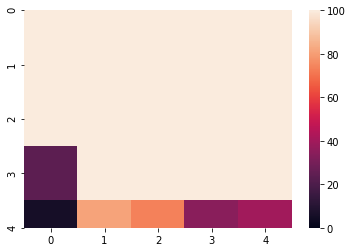

In [18]:
# Heatmap of recalls
mat = sns.heatmap(M, vmin=0, vmax=100)
plt.show()

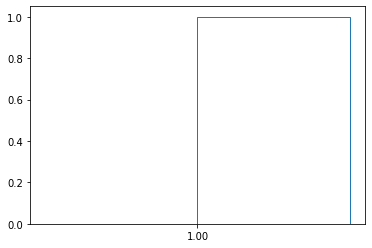

In [19]:
# AUC (one config for now)
unknown, binding = scores[0]
total = unknown + binding
plt.hist(total, 50, histtype='step', density=True, cumulative=True)
plt.show()

## Test other NN models

In [20]:
# model = TwoLayer()
# model.apply(weights_init)
# model.cuda()
# print("Training...")
# sgd(t=1000, gamma=0.01, lamb=0.01)
# print("Evaluating...")
# # use for AUC
# recall, binding_outputs = recall_eval(50)
# unknown_outputs = evaluate(500)
# # use for heatmap
# print("Recall with gamma: "+ str(0.01) + " , lambda: " + str(0.01) + " recall: ", '%.2f'% recall)